# February, 13th 2021 (under construction)

**Motivation**: Simple analysis on data. Learn how it is structured, come up with clarification questions.<br>
**Results**:  In this document I focus on Ca sinals.

In [1]:
# HIDE CODE


import re
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.stats import pearsonr
from os.path import join as pjoin
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# HIDE CODE


data_dir = '/home/hadi/Documents/Ca-fMRI'
p = re.compile("part-\d")

ca_tmp = {}
ca = {}
bold = {}

animals = ['sub-SLC07', 'sub-SLC08']

for file_name in sorted(os.listdir(data_dir)):
    meta = file_name.split('_')
    sub = next(filter(lambda x: 'sub' in x, meta))
    ses = next(filter(lambda x: 'ses' in x, meta))
    run = next(filter(lambda x: 'run' in x, meta))
    task = next(filter(lambda x: 'task' in x, meta))
    key = '_'.join([sub, ses, run, task])
    
    skip = True
    for item in animals:
        if item in file_name:
            skip = False
    if skip:
        continue
    
    
    with open(pjoin(data_dir, file_name)) as f:
        data = nib.load(f.name).get_fdata()
    
    if 'bold' in file_name:
        bold[key] = data
    elif 'ca' in file_name:
        key += ':' + p.search(file_name).group(0)
        ca_tmp[key] = data
    else:
        print(file_name)
        continue

for k in bold:
    _ca_data = []
    for i in range(1, 4):
        _ca_data.append(ca_tmp[k + ':part-{:d}'.format(i)])
    ca[k] = np.concatenate(_ca_data, axis=-1)
    
ca = {k: ca[k] for k in sorted(ca)}
bold = {k: bold[k] for k in sorted(bold)}

bold.keys(), ca.keys()

(dict_keys(['sub-SLC07_ses-2_run-1_task-rest', 'sub-SLC07_ses-2_run-2_task-led', 'sub-SLC07_ses-2_run-3_task-rest', 'sub-SLC07_ses-2_run-4_task-led', 'sub-SLC07_ses-2_run-5_task-rest', 'sub-SLC07_ses-2_run-6_task-led', 'sub-SLC07_ses-2_run-7_task-rest']),
 dict_keys(['sub-SLC07_ses-2_run-1_task-rest', 'sub-SLC07_ses-2_run-2_task-led', 'sub-SLC07_ses-2_run-3_task-rest', 'sub-SLC07_ses-2_run-4_task-led', 'sub-SLC07_ses-2_run-5_task-rest', 'sub-SLC07_ses-2_run-6_task-led', 'sub-SLC07_ses-2_run-7_task-rest']))

In [3]:
[item.shape for item in bold.values()], [item.shape for item in ca.values()]

([(64, 64, 78, 600),
  (64, 64, 78, 600),
  (64, 64, 78, 600),
  (64, 64, 78, 600),
  (64, 64, 78, 600),
  (64, 64, 78, 600),
  (64, 64, 78, 600)],
 [(256, 250, 1, 6000),
  (256, 250, 1, 5999),
  (256, 250, 1, 6000),
  (256, 250, 1, 6000),
  (256, 250, 1, 6000),
  (256, 250, 1, 6000),
  (256, 250, 1, 5999)])

In [21]:
key = 'sub-SLC07_ses-2_run-7_task-rest'

nt = bold[key].shape[-1]
ca_frequency = 10
exclude_seconds = 50
start = ca[key].shape[-1] - ((nt - exclude_seconds) * ca_frequency)
end = ca[key].shape[-1]

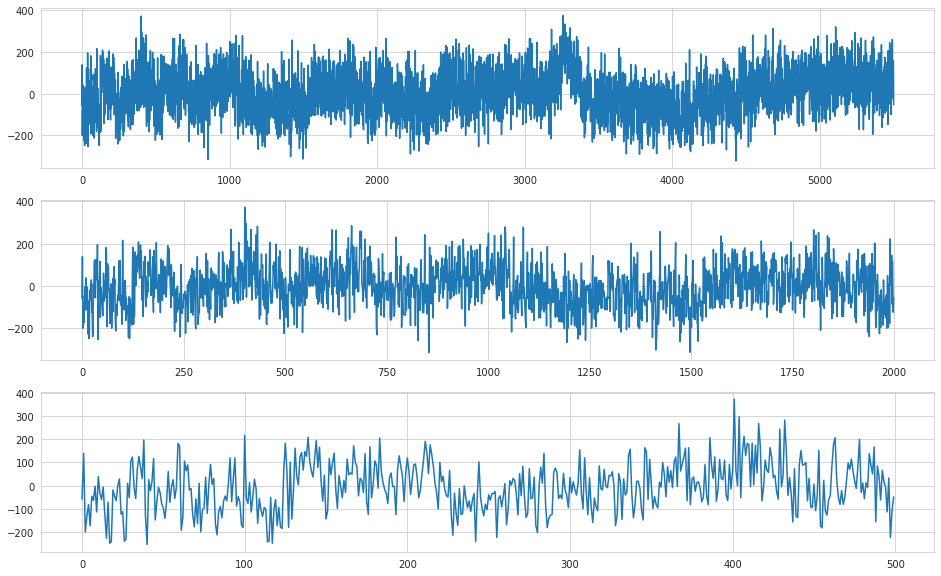

In [22]:
plt.figure(figsize=(16, 10))
plt.subplot(311)
plt.plot(ca[key][128, 90, 0][start:end])
plt.subplot(312)
plt.plot(ca[key][128, 90, 0][start:start+2000])
plt.subplot(313)
plt.plot(ca[key][128, 90, 0][start:start+500])

In [14]:
source = (128, 128, 0)

In [15]:
corrs = np.zeros(ca[key].shape[:-1])
corrs.shape

(256, 250, 1)

In [8]:
for i in tqdm(range(ca[key].shape[0])):
    for j in range(ca[key].shape[1]):
        for k in range(ca[key].shape[2]):
            r, p = pearsonr(ca[key][i, j, k, :], ca[key][source[0], source[1], source[2], :])
            if not np.isnan(r):
                corrs[i, j, k] = r

/home/hadi/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [9]:
corrs.shape

(256, 250, 1)

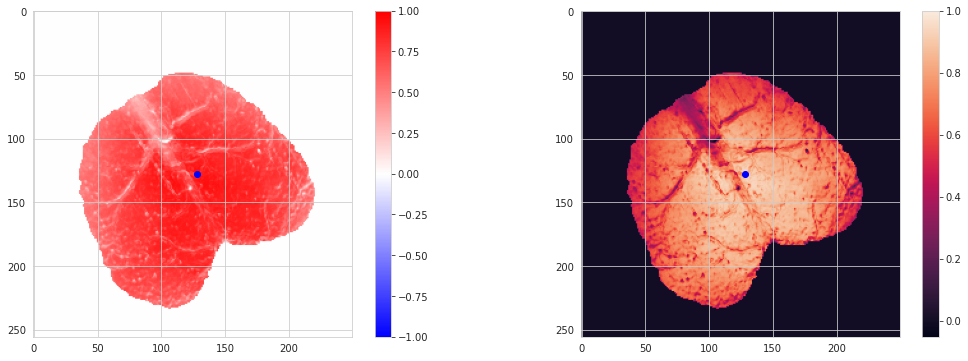

In [10]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.imshow(corrs[..., 0], vmin=-1, vmax=1, cmap='bwr')
plt.plot(source[0], source[1], color='b', marker='o')
plt.colorbar()

plt.subplot(122)
plt.imshow(corrs[..., 0])
plt.plot(source[0], source[1], color='b', marker='o')
plt.colorbar()

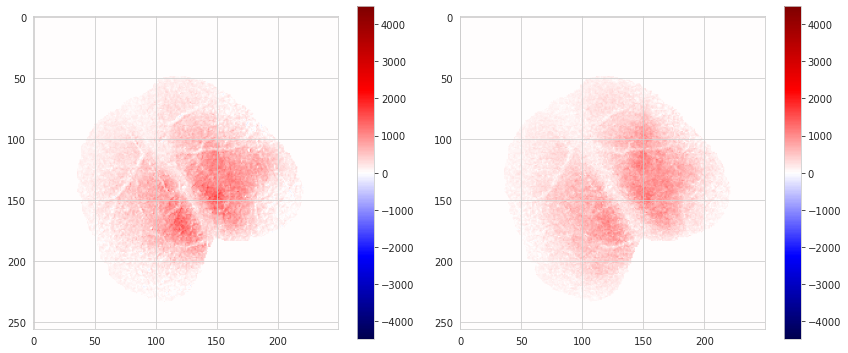

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.imshow(ca[key][..., 1070], vmin=-ca[key].max(), vmax=ca[key].max(), cmap='seismic')
plt.colorbar()

plt.subplot(122)
plt.imshow(ca[key][..., 1130], vmin=-ca[key].max(), vmax=ca[key].max(), cmap='seismic')
plt.colorbar()

plt.tight_layout()
plt.show()

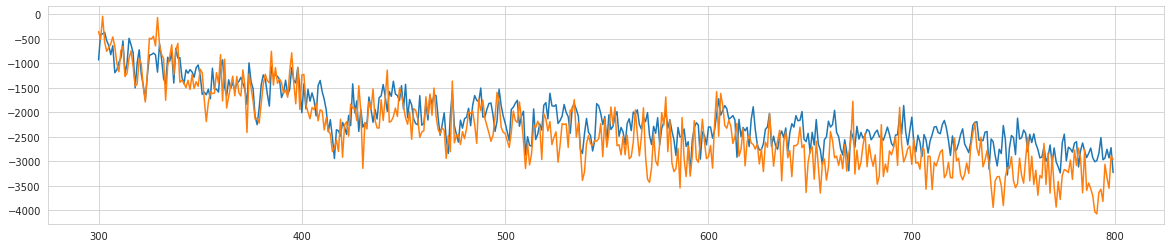

In [29]:
intvl = range(300, 800)

plt.figure(figsize=(20, 4))
plt.plot(intvl, ca[key][128, 128, 0][intvl])
plt.plot(intvl, ca[key][128, 129, 0][intvl])

In [30]:
np.unravel_index(ca[key].argmin(), ca[key].shape)

(79, 83, 0, 1)

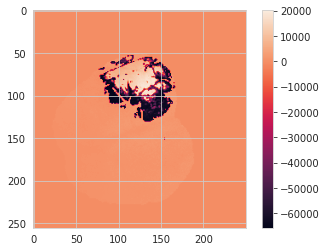

In [31]:
plt.imshow(ca[key][..., 0, 0])
plt.colorbar()

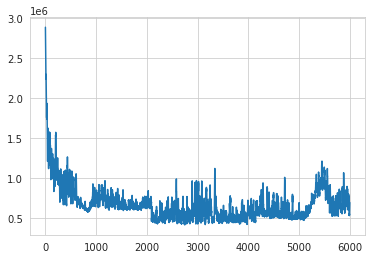

In [32]:
norm = np.linalg.norm(ca[key].reshape(-1, ca[key].shape[-1]), axis=0)

plt.plot(norm)

In [33]:
X = ca[key][..., 0, :].copy()
X[X<0] += np.abs(np.mean(X[X<0]))
X = np.maximum(0.0, X)

nt = bold[key].shape[-1]
ca_frequency = 10
exclude_seconds = 10
start = ca[key].shape[-1] - ((nt - exclude_seconds) * ca_frequency)
end = ca[key].shape[-1]

X = X[..., range(start, end)]
X /= X.std()
X.shape

(256, 250, 5900)

In [34]:
X.var()

0.9999999999999973

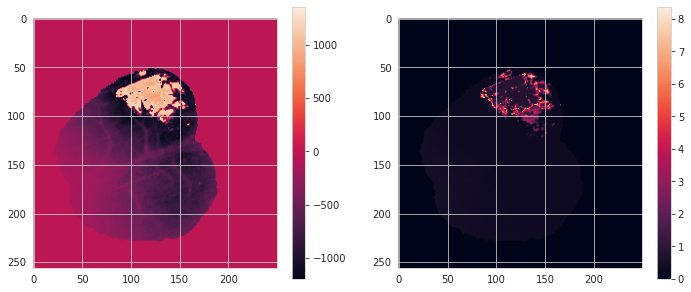

In [35]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.imshow(ca[key].mean(-1)[..., 0])
plt.colorbar()

plt.subplot(122)
plt.imshow(X.mean(-1))
plt.colorbar()

plt.show()

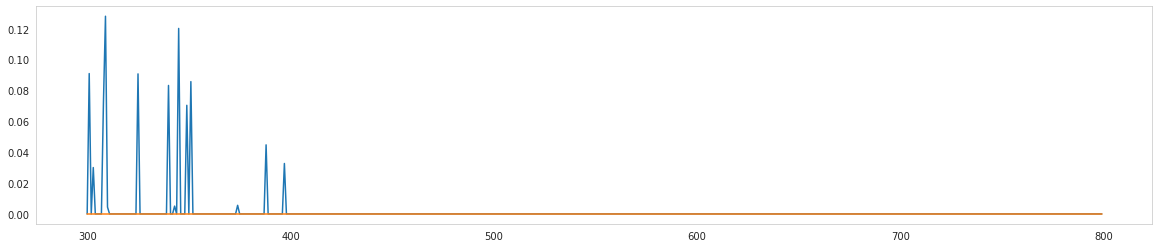

In [36]:
intvl = range(300, 800)

plt.figure(figsize=(20, 4))
plt.plot(intvl, X[128, 128][intvl])
plt.plot(intvl, X[128, 200][intvl])
plt.grid()

In [222]:
X = X.reshape(-1, X.shape[-1]).T
X.shape

(5900, 64000)

In [223]:
from sklearn.decomposition import NMF

model = NMF(
    n_components=8,
    init='nndsvd',
    max_iter=1000,
    random_state=42,
)
W = model.fit_transform(X)

In [224]:
model.components_.shape, model.reconstruction_err_

((8, 64000), 12975.70362514647)

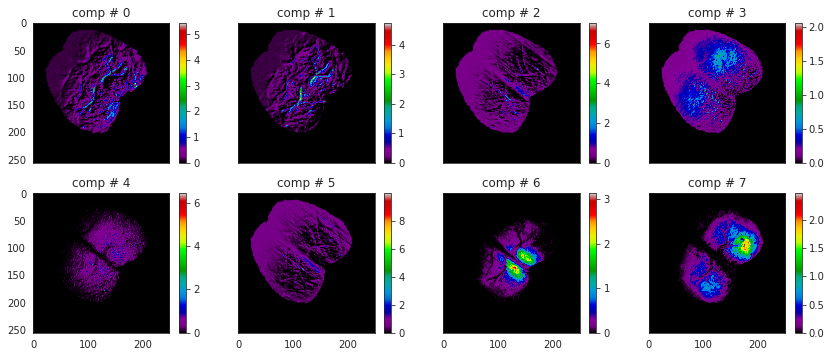

In [225]:
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5), sharex='all', sharey='all')

for c in range(model.n_components_):
    i, j = c // ncols, c % ncols
    comp = model.components_[c].reshape(ca[key].shape[:2])
    im = axes[i, j].imshow(comp, cmap='nipy_spectral')#'' 'gist_ncar')
    axes[i, j].set_title('comp # {:d}'.format(c))
    plt.colorbar(im, ax=axes[i, j])
    
fig.tight_layout()
plt.show()

In [169]:
X.shape, W.shape

((5900, 64000), (5900, 8))

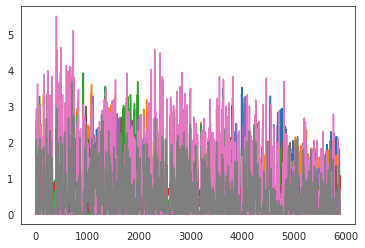

In [170]:
plt.plot(W);

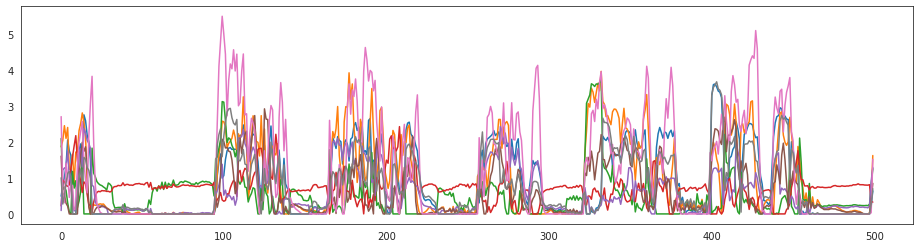

In [171]:
intvl = range(300, 800)

plt.figure(figsize=(16, 4))
plt.plot(W[intvl]);

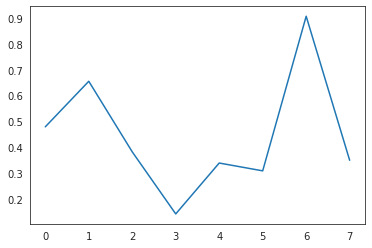

In [172]:
plt.plot(W.var(0))

In [173]:
np.argsort(W.var(0))

array([3, 5, 4, 7, 2, 0, 1, 6])

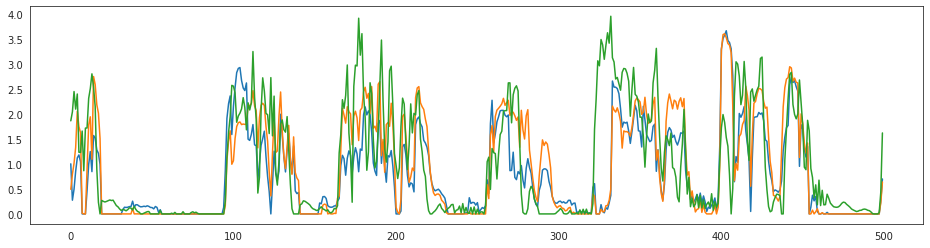

In [174]:
intvl = range(300, 800)
plt.figure(figsize=(16, 4))
plt.plot(W[intvl][:, [7, 0, 1]])

In [175]:
X_pred = model.inverse_transform(W)
X_pred.shape

(5900, 64000)

In [176]:
X.shape

(5900, 64000)

In [177]:
from sklearn.metrics import r2_score

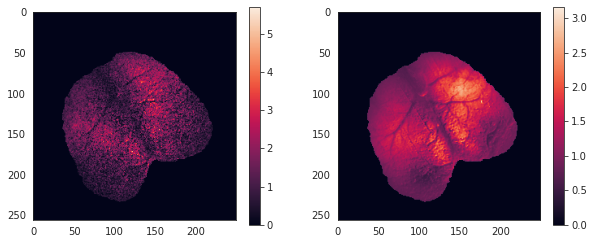

In [178]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(X[500].reshape(*ca[key].shape[:2]))
plt.colorbar()

plt.subplot(122)
plt.imshow(X_pred[500].reshape(*ca[key].shape[:2]))
plt.colorbar()

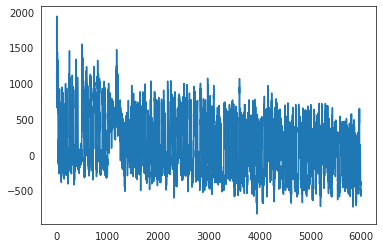

In [182]:
plt.plot(ca[key][128, 128, 0])

In [183]:
def smoothen(arr: np.ndarray, filter_sz: int = 5):
    shape = arr.shape
    assert 1 <= len(shape) <= 2, "1 <= dim <= 2d"

    kernel = np.ones(filter_sz) / filter_sz
    if len(shape) == 1:
        return np.convolve(arr, kernel, mode='same')
    else:
        smoothed = np.zeros(arr.shape)
        for i in range(arr.shape[0]):
            smoothed[i] = np.convolve(arr[i], kernel, mode='same')
        return smoothed

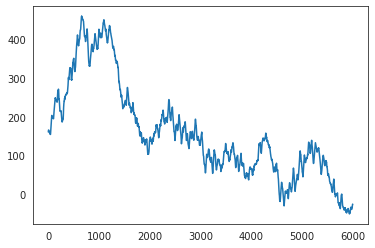

In [192]:
smothed = smoothen(ca[key][128, 128, 0], filter_sz=400)


plt.plot(smothed)

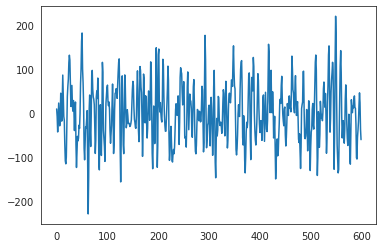

In [193]:
plt.plot(bold[key][30, 30, 30])

In [179]:
indxs = np.argsort(W[:, 3] - W[:, 6])

indxs[:10], indxs[-10:]

(array([ 399,  727,  400, 2305,  728, 2409,  398,  593,  487,  675]),
 array([105, 104, 938,  16, 106, 812, 508,  85,  17, 813]))

In [180]:
plot_indxs = [813, 508, 106, 2305, 727, 399]
# plot_indxs = [x + 99 for x in plot_indxs]
# good stuff: [203, 386, 195, 67, 418, 1609]

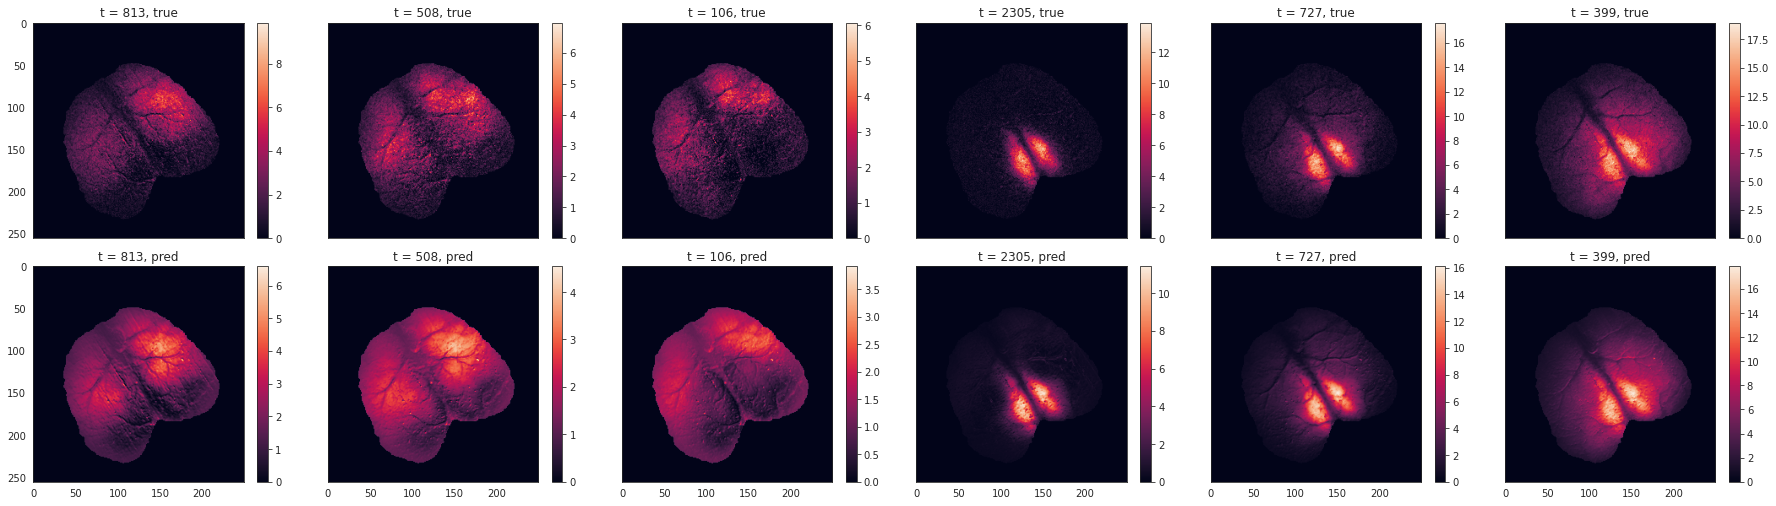

In [181]:
nrows, ncols = 2, len(plot_indxs)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 7), sharex='all', sharey='all')

vmax = np.max(X[plot_indxs])
vmin = np.min(X[plot_indxs])

for c in range(ncols):
    t = plot_indxs[c]
    
    im = axes[0, c].imshow(X[t].reshape(*ca[key].shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[0, c].set_title('t = {:d}, true'.format(t))
    plt.colorbar(im, ax=axes[0, c])
    
    im = axes[1, c].imshow(X_pred[t].reshape(*ca[key].shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[1, c].set_title('t = {:d}, pred'.format(t))
    plt.colorbar(im, ax=axes[1, c])
    
fig.tight_layout()
plt.show()

In [731]:
norms = np.linalg.norm(data2.reshape(-1, data2.shape[-1]), ord=np.inf, axis=0)
norms.shape

(2090,)

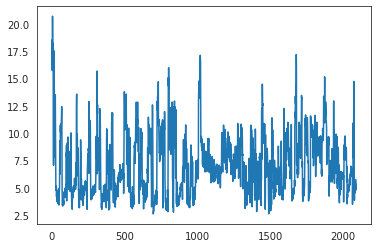

In [588]:
plt.plot(norms)

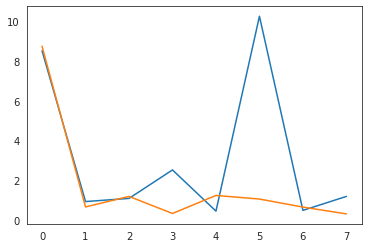

In [558]:
plt.plot(W[3])
plt.plot(W[1360])

### ICA

In [593]:
X = data2.reshape(-1, data2.shape[-1]).T
# X += abs(X.min())
X.shape

(2090, 64000)

In [594]:
from sklearn.decomposition import FastICA
ica = FastICA(
    n_components=8,
    random_state=42,
)
X_ica = ica.fit_transform(X)
X_ica.shape

(2090, 8)

In [596]:
ica.components_.shape

(8, 64000)

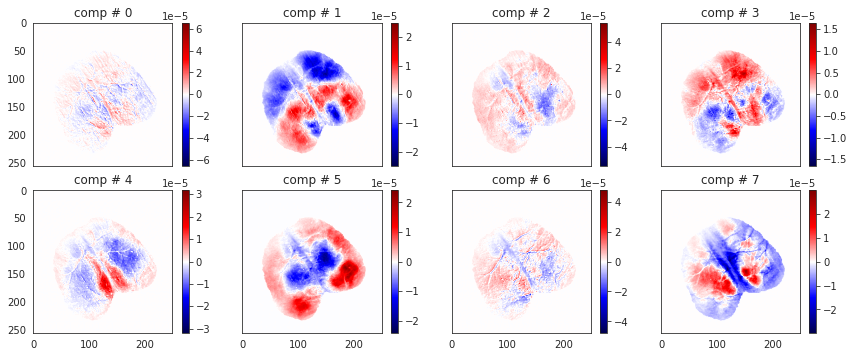

In [603]:
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5), sharex='all', sharey='all')

for c in range(model.n_components_):
    i, j = c // ncols, c % ncols
    comp = ica.components_[c].reshape(data2.shape[:2])
    vmax = np.max(np.abs(comp))
    im = axes[i, j].imshow(comp, cmap='seismic', vmin=-vmax, vmax=vmax)#'' 'gist_ncar')
    axes[i, j].set_title('comp # {:d}'.format(c))
    plt.colorbar(im, ax=axes[i, j])
    
fig.tight_layout()
plt.show()

In [604]:
X_ica.shape

(2090, 8)

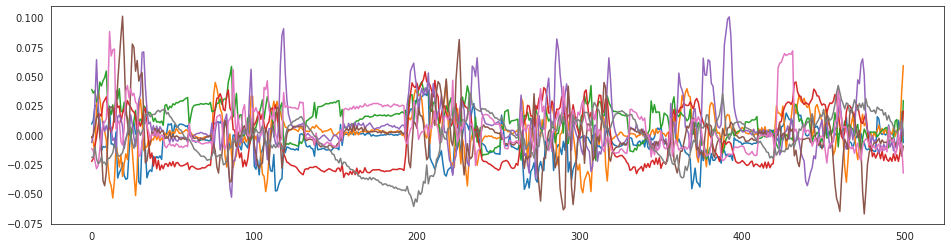

In [606]:
intvl = range(300, 800)

plt.figure(figsize=(16, 4))
plt.plot(X_ica[intvl]);

In [609]:
X_ica.var(0)

array([0.00047847, 0.00047847, 0.00047847, 0.00047847, 0.00047847,
       0.00047847, 0.00047847, 0.00047847])

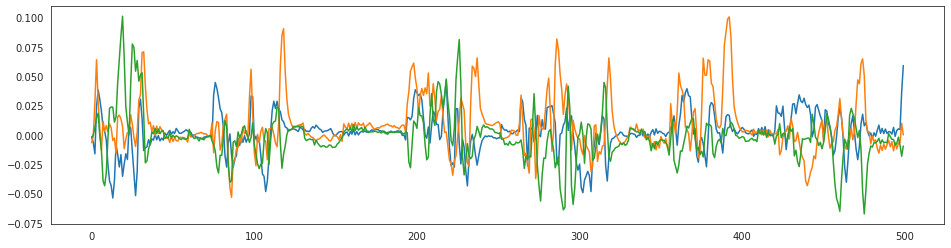

In [610]:
intvl = range(300, 800)
plt.figure(figsize=(16, 4))
plt.plot(X_ica[intvl][:, [1, 4, 5]])

In [611]:
X_pred = ica.inverse_transform(X_ica)
X_pred.shape

(2090, 64000)

In [612]:
X.shape

(2090, 64000)

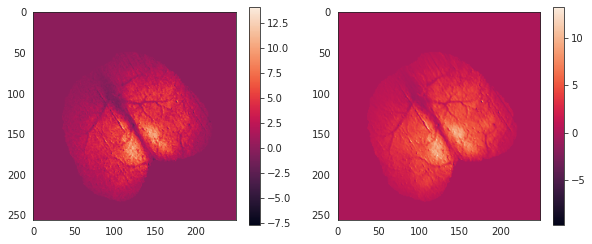

In [613]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(X[10].reshape(*data2.shape[:2]))
plt.colorbar()

plt.subplot(122)
plt.imshow(X_pred[10].reshape(*data2.shape[:2]))
plt.colorbar()

In [614]:
indxs = np.argsort(X_ica[:, 4] - X_ica[:, 5])

indxs[:10], indxs[-10:]

(array([  2,   0,  22,  25,  23,  24,   1,  26, 116,  18]),
 array([132, 827, 774, 417, 775, 826,  66,  69,  67,  68]))

In [616]:
plot_indxs = [68, 826, 417, 22, 116, 18]

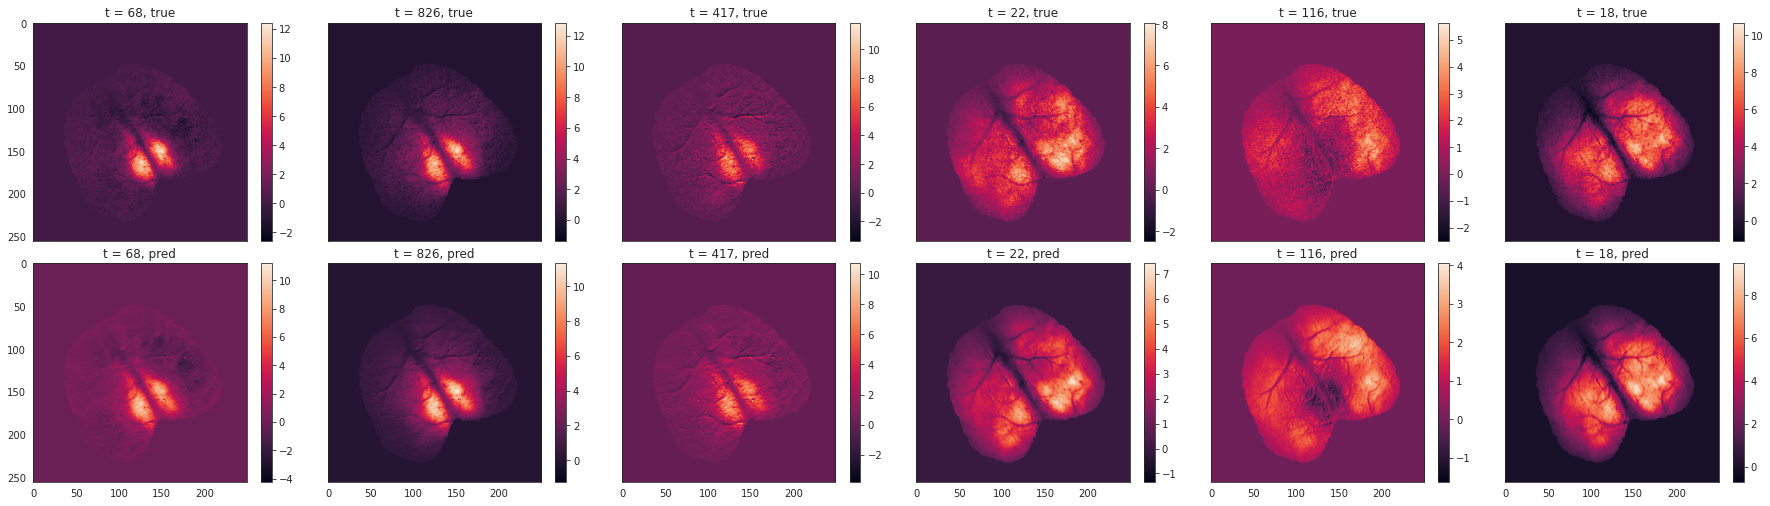

In [617]:
nrows, ncols = 2, len(plot_indxs)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 7), sharex='all', sharey='all')

vmax = np.max(X[plot_indxs])
vmin = np.min(X[plot_indxs])

for c in range(ncols):
    t = plot_indxs[c]
    
    im = axes[0, c].imshow(X[t].reshape(*data2.shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[0, c].set_title('t = {:d}, true'.format(t))
    plt.colorbar(im, ax=axes[0, c])
    
    im = axes[1, c].imshow(X_pred[t].reshape(*data2.shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[1, c].set_title('t = {:d}, pred'.format(t))
    plt.colorbar(im, ax=axes[1, c])
    
fig.tight_layout()
plt.show()

### PCA

In [619]:
from sklearn.decomposition import PCA

pca = PCA(
    n_components=8,
    svd_solver='full',
)
X_pca = pca.fit_transform(X)
X_pca.shape

(2090, 8)

In [622]:
pca.components_.shape, pca.explained_variance_ratio_ * 100

((8, 64000),
 array([75.68989764,  5.50015838,  3.41498745,  1.88958672,  1.3358353 ,
         1.04752444,  0.78383764,  0.7476424 ]))

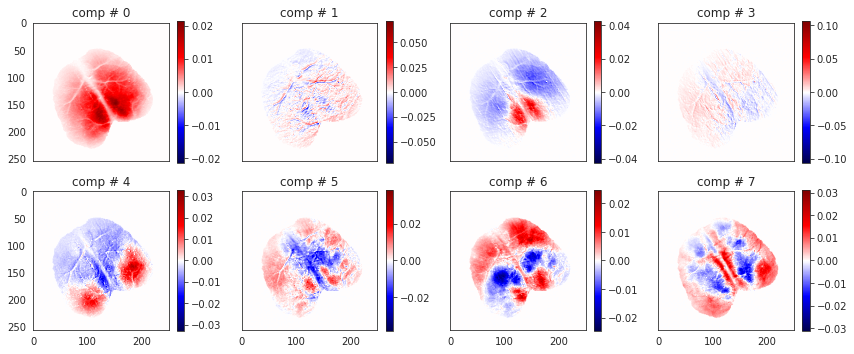

In [623]:
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5), sharex='all', sharey='all')

for c in range(model.n_components_):
    i, j = c // ncols, c % ncols
    comp = pca.components_[c].reshape(data2.shape[:2])
    vmax = np.max(np.abs(comp))
    im = axes[i, j].imshow(comp, cmap='seismic', vmin=-vmax, vmax=vmax)#'' 'gist_ncar')
    axes[i, j].set_title('comp # {:d}'.format(c))
    plt.colorbar(im, ax=axes[i, j])
    
fig.tight_layout()
plt.show()

### This could mean either of two things:

1. Those regions were more active (dorsal?)
2. Or this is an artifact inherent to the data.  E.g. those parts of the cortex were not more active, but the light was more accessible to the microscope from those regions?

In [624]:
X_pca.shape

(2090, 8)

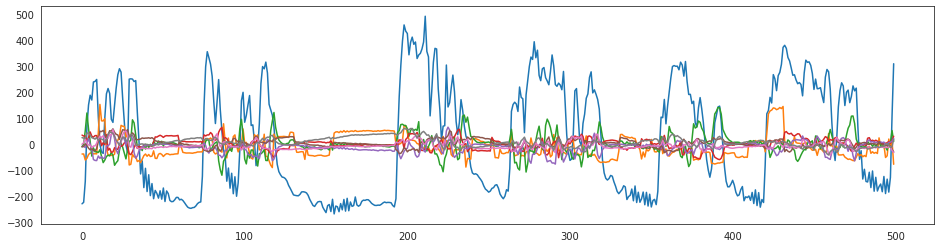

In [625]:
intvl = range(300, 800)

plt.figure(figsize=(16, 4))
plt.plot(X_pca[intvl]);

In [626]:
X_pca.var(0)

array([35893.84747916,  2608.29849228,  1619.46365988,   896.08441395,
         633.48306814,   496.7595914 ,   371.71339127,   354.54880014])

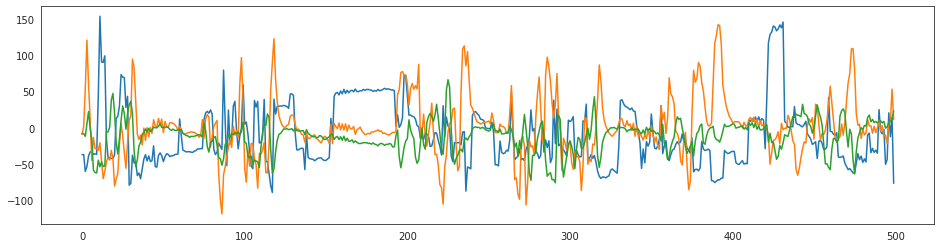

In [629]:
intvl = range(300, 800)
plt.figure(figsize=(16, 4))
plt.plot(X_pca[intvl][:, [1, 2, 4]])

In [630]:
X_pred = pca.inverse_transform(X_pca)
X_pred.shape

(2090, 64000)

In [631]:
X.shape

(2090, 64000)

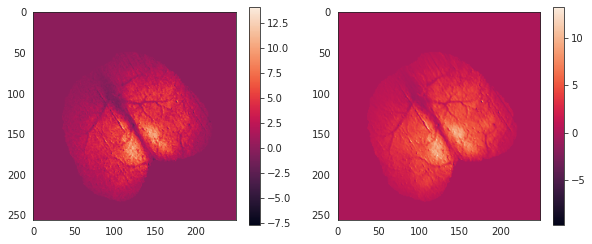

In [632]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(X[10].reshape(*data2.shape[:2]))
plt.colorbar()

plt.subplot(122)
plt.imshow(X_pred[10].reshape(*data2.shape[:2]))
plt.colorbar()

In [639]:
indxs = np.argsort(X_pca[:, 4] - X_pca[:, 2])

indxs[:10], indxs[-10:]

(array([ 67,  68,  66,  69,  65, 826,  14, 827, 418, 132]),
 array([1682,   23, 1683,   19,   24,    2,   25,    1,   18,    0]))

In [640]:
plot_indxs = [18, 25, 1683, 67, 826, 418]
# [68, 826, 417, 22, 116, 18]

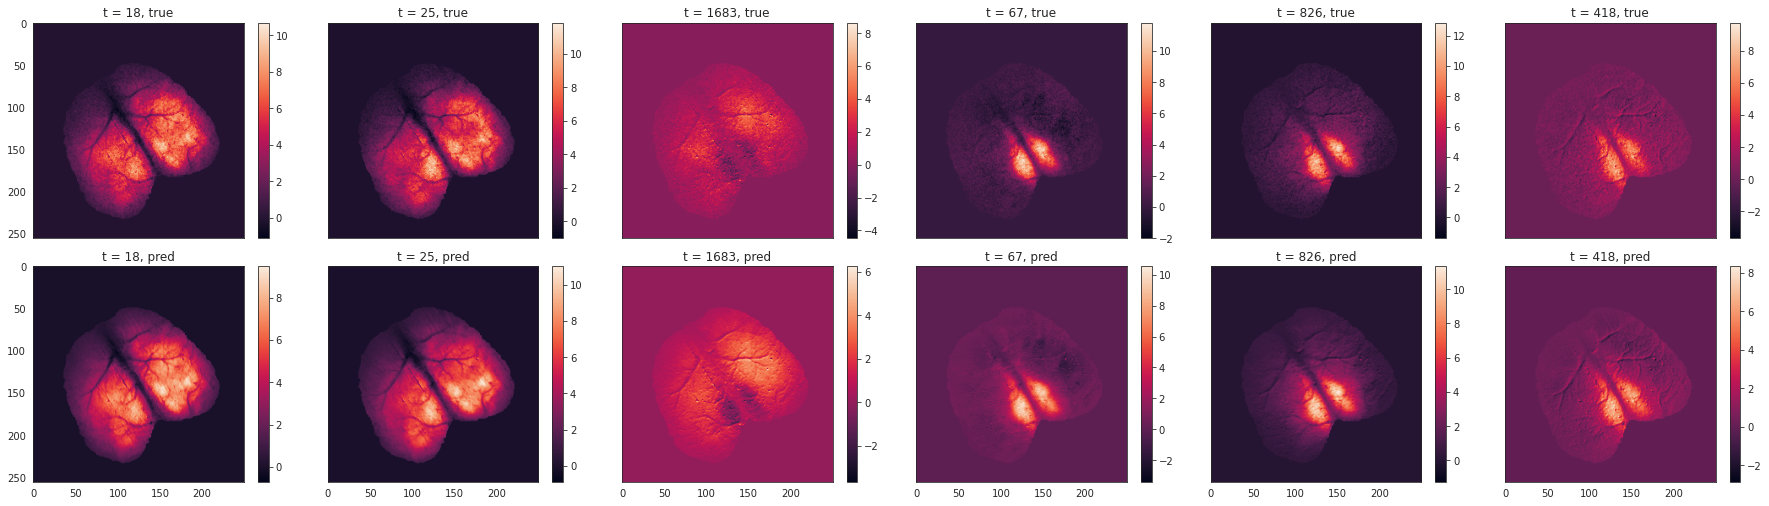

In [641]:
nrows, ncols = 2, len(plot_indxs)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 7), sharex='all', sharey='all')

vmax = np.max(X[plot_indxs])
vmin = np.min(X[plot_indxs])

for c in range(ncols):
    t = plot_indxs[c]
    
    im = axes[0, c].imshow(X[t].reshape(*data2.shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[0, c].set_title('t = {:d}, true'.format(t))
    plt.colorbar(im, ax=axes[0, c])
    
    im = axes[1, c].imshow(X_pred[t].reshape(*data2.shape[:2]))#, vmin=vmin, vmax=vmax)
    axes[1, c].set_title('t = {:d}, pred'.format(t))
    plt.colorbar(im, ax=axes[1, c])
    
fig.tight_layout()
plt.show()

In [643]:
r2_score(X, X_pred) * 100

89.3953570126434

### fMRI

In [472]:
X = data.reshape(-1, data.shape[-1]).T
X += abs(X.min())
X.shape

(600, 319488)

In [473]:
from sklearn.decomposition import NMF

model = NMF(
    n_components=16,
    # alpha=1,
    # l1_ratio=1,
    init='nndsvd',
    max_iter=300,
    random_state=42,
)
W = model.fit_transform(X)

/home/hadi/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [474]:
model.components_.shape, model.reconstruction_err_

((16, 319488), 508907.3728253777)

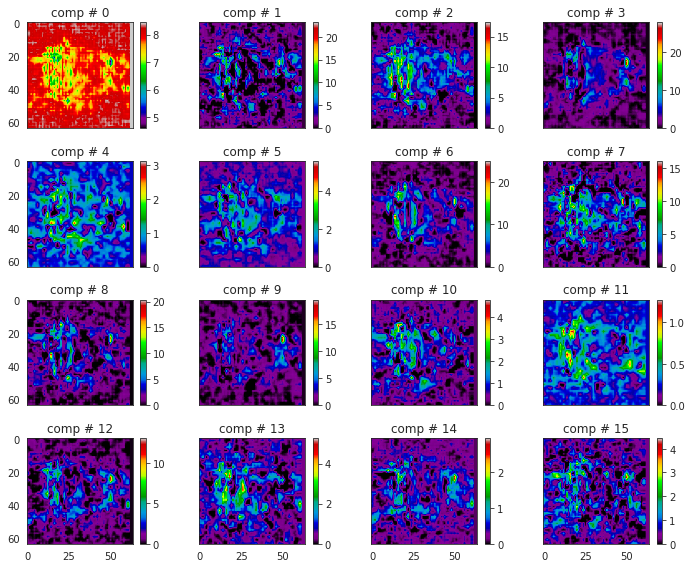

In [488]:
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8), sharex='all', sharey='all')

for c in range(model.n_components_):
    i, j = c // ncols, c % ncols
    comp = model.components_[c].reshape(data.shape[:3])
    im = axes[i, j].imshow(comp[..., 17], cmap='nipy_spectral')#'' 'gist_ncar')
    axes[i, j].set_title('comp # {:d}'.format(c))
    plt.colorbar(im, ax=axes[i, j])
    
fig.tight_layout()
plt.show()